# Optimization of Random Forest classifier

In the following, we evaluate different training protocols and versions of the Rhapsody classifier, in order to optimize performances. More specifically, we considered:
* different subsets of the training dataset
* different feature sets
* different hyperparameters.

In [1]:
import sys, os
import pickle
import numpy as np
from glob import glob
from prody import LOGGER

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.family': 'Arial'})

In [3]:
# If needed, insert here local path to Rhapsody folder with the command:
# sys.path.insert(0, '/LOCAL_PATH/rhapsody/')
import rhapsody as rd

In [4]:
if not os.path.isdir('local'):
    os.mkdir('local')

## Importing the training dataset

The Integrated Dataset used for training is available as a NumPy structured array containing all precomputed features, as well as true labels and other info (e.g. PDB lengths).

The Integrated Dataset has been built by merging 7 publicly available datasets of labelled human missense variants (HumVar, ExoVar, predictSNP, VariBench, SwissVar, Humsavar, ClinVar). Variants with discordant interpretations between datasets have `true_label = -1`. See `Training_Dataset` tutorial for more details.

In [5]:
# please make sure to extract the data folder beforehand
ID = np.load('../1-Training_Dataset/local/data/precomputed_features-ID.npy')

In [6]:
# array structure
print(ID.dtype.names)

('SAV_coords', 'Uniprot2PDB', 'PDB_length', 'true_label', 'ANM_MSF-chain', 'ANM_MSF-reduced', 'ANM_MSF-sliced', 'ANM_effectiveness-chain', 'ANM_effectiveness-reduced', 'ANM_effectiveness-sliced', 'ANM_sensitivity-chain', 'ANM_sensitivity-reduced', 'ANM_sensitivity-sliced', 'BLOSUM', 'Delta_PSIC', 'Delta_SASA', 'EVmut-DeltaE_epist', 'EVmut-DeltaE_indep', 'EVmut-mut_aa_freq', 'EVmut-wt_aa_cons', 'GNM_MSF-chain', 'GNM_MSF-reduced', 'GNM_MSF-sliced', 'GNM_effectiveness-chain', 'GNM_effectiveness-reduced', 'GNM_effectiveness-sliced', 'GNM_sensitivity-chain', 'GNM_sensitivity-reduced', 'GNM_sensitivity-sliced', 'SASA', 'SASA_in_complex', 'entropy', 'ranked_MI', 'stiffness-chain', 'stiffness-reduced', 'stiffness-sliced', 'wt_PSIC')


In [7]:
# each entry can be accessed by indexing
ID[0]

('A0AV02 181 R C', 'Unable to map SAV to PDB', 0, 0, nan, nan, nan, nan, nan, nan, nan, nan, nan, -3., 3.805, nan, -8.3871, -7.7763, 0., 0.5921, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 1.217494, 0.6424731, nan, nan, nan, -1.217)

In [8]:
# size of the training dataset
len(ID)

91697

In [9]:
# let's discard SAVs with unknown significance (true_label == -1)
ID = ID[ID['true_label'] != -1]
len(ID)

87726

In [10]:
# number of entries with an associated PDB structure
sum(ID['PDB_length' ] > 0)

27655

## Dataset filtering based on ClinVar review status

Each entry in the ClinVar dataset is assigned with a review "star", between 0 to 4, which indicates the quality of the clinical interpretation, based on consensus between sources. 

We start by analyzing the impact on the classifier's accuracy of increasingly strict constraints on SAVs quality (at least for SAVs found in the ClinVar database).

For this analysis, we will make a couple of reasonable assumptions that will be justified *a posteriori* in the next sections, for instance:
* we will discard SAVs mapped to PDB structures smaller than 150 residues
* we will select a specific set of features (see below)

In [11]:
ID_SAVs_info = np.load('../1-Training_Dataset/local/data/Integrated_Dataset-SAVs.npy')
ID_SAVs_info.dtype

dtype([('SAV_coords', '<U50'), ('true_label', '<i2'), ('datasets', '<U100'), ('ClinVar_review_star', '<i2')])

In [12]:
from collections import Counter

count = Counter(ID_SAVs_info['ClinVar_review_star'])

print('review star   n. SAVs')
for star in range(5):
    print(f'{star:>11} {count[star]:>9}')
    
print(f'SAVs without ClinVar review star: {count[-1]}')

review star   n. SAVs
          0      9752
          1      5324
          2      5182
          3       548
          4         8
SAVs without ClinVar review star: 73691


In [13]:
ClinVar_review_stars = {
    s['SAV_coords']: s['ClinVar_review_star'] for s in ID_SAVs_info
}

In [14]:
featset = rd.DEFAULT_FEATSETS['full']
featset

['wt_PSIC',
 'Delta_PSIC',
 'SASA',
 'ANM_MSF-chain',
 'ANM_effectiveness-chain',
 'ANM_sensitivity-chain',
 'stiffness-chain',
 'entropy',
 'ranked_MI',
 'BLOSUM']

In [15]:
if not os.path.isdir('local/results'):
    os.mkdir('local/results')

In [16]:
if os.path.isfile('local/results/CV_summaries_1.pkl'):
    CV_summaries_1 = pickle.load(open('local/results/CV_summaries_1.pkl', 'rb'))
    print('A pickle containing precomputed results has been found. \n'
          'Please delete it if you wish to run the analysis again. \n'
          'Log saved in local/results/RF_optimization_1.log \n')
    ! head -10 local/results/RF_optimization_1.log; echo '...'
else:
    # let's consider only PDBs larger than 150 residues
    ID_150 = ID[ ID['PDB_length'] >= 150 ]

    # cycle of cross-validation tests after excluding ClinVar SAVs 
    # with increasing reliability ranking (= review star) from training dataset

    CV_summaries_1 = {}
    
    LOGGER.start('local/results/RF_optimization_1.log')

    for star in range(6):
        
        # we exclude SAVs with review star smaller than given value 
        # (if ClinVar's rating is found)
        ID_subset = ID_150[ [ClinVar_review_stars[SAV]==-1 or 
                             ClinVar_review_stars[SAV] >= star 
                             for SAV in ID_150['SAV_coords']] ]

        LOGGER.info(f'REVIEW STAR: {star:1}')
        LOGGER.info(f'SAVs removed from ID: {len(ID_150)-len(ID_subset):4}')

        # create folder
        folder = f'local/results/review_star-{star}'
        os.mkdir(folder)
        
        # run cross-validation
        sel = ['SAV_coords', 'true_label'] + featset
        ID_subset = ID_subset[sel]
        CV_summaries_1[star] = rd.RandomForestCV(ID_subset)

        # move figures into folder
        for file in glob('*png'):
            os.rename(file, os.path.join(folder, file))

        LOGGER.info('')

    # store all cross-validation results into a pickle
    pickle.dump(CV_summaries_1, open('local/results/CV_summaries_1.pkl', 'wb'))

    LOGGER.close('local/results/RF_optimization_1.log')

A pickle containing precomputed results has been found. 
Please delete it if you wish to run the analysis again. 
Log saved in local/results/RF_optimization_1.log 

Logging started at 2019-10-25 19:26:02.190446
REVIEW STAR: 0
SAVs removed from ID:    0
4381 out of 23085 cases ignored with missing features.
CV iteration # 1:   AUROC = 0.849   AUPRC = 0.920   OOB score = 0.819
CV iteration # 2:   AUROC = 0.854   AUPRC = 0.927   OOB score = 0.818
CV iteration # 3:   AUROC = 0.863   AUPRC = 0.937   OOB score = 0.820
CV iteration # 4:   AUROC = 0.854   AUPRC = 0.927   OOB score = 0.818
CV iteration # 5:   AUROC = 0.856   AUPRC = 0.927   OOB score = 0.817
CV iteration # 6:   AUROC = 0.850   AUPRC = 0.927   OOB score = 0.820
...


In [17]:
if not os.path.isdir('local/figures'):
    os.mkdir('local/figures')

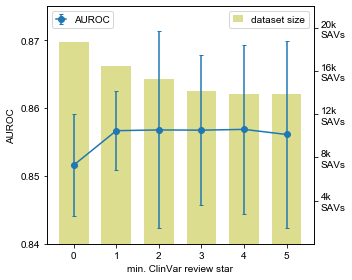

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))

x = range(6)

y = np.array([CV_summaries_1[n]['mean AUROC'][0] for n in x])
e = np.array([CV_summaries_1[n]['mean AUROC'][1] for n in x])
ax.errorbar(x, y, yerr=e, marker='o', capsize=2, label='AUROC')

ax2 = ax.twinx()
hb = ax2.bar(x, [CV_summaries_1[n]['dataset size'] for n in x], 
             color = 'C8', width=.7, alpha=0.5, label='dataset size')
ax2.set_zorder(ax.get_zorder()-1)
ax.patch.set_visible(False)

ax.set_xlabel('min. ClinVar review star')
ax.set_ylabel('AUROC')
ax.set_ylim((.84, .875))
ax.locator_params(nbins=5, axis='y')

ax2.set_ylim((0, 22000))
ax2.set_yticks(range(4000, 20001, 4000))
ax2.set_yticklabels(['4k\nSAVs', '8k\nSAVs', '12k\nSAVs', '16k\nSAVs', '20k\nSAVs'])

ax.legend(handlelength=1, loc='upper left')
ax2.legend(handlelength=1)

plt.tight_layout()
fig.savefig('local/figures/accuracy_vs_review_star.png', dpi=300)

Based on these results, we will exclude from our training dataset SAVs with a ClinVar review star = 0.

In [19]:
original_ID = ID

ID = ID[ [ClinVar_review_stars[SAV] != 0 for SAV in ID['SAV_coords']] ]
print('original dataset size:', len(original_ID))
print('filtered dataset size:', len(ID))

original dataset size: 87726
filtered dataset size: 80215


## 2. Cross-validation with various classification schemes

Next, we test different combinations of features and training datasets, specifically:

* different subsets of the training dataset, obtained by setting a minimum PDB structure size
* 4 different feature sets, including one reproducing version 1 of the method (RAPSODY)
* **GNM** vs **ANM** features
* ENM features computed with and without the inclusion of *enviromental* effects (**chain**, **reduced** or **sliced** models), i.e. the presence of other chains in the PDB structure

In [20]:
# this cell requires a few hours to complete

if os.path.isfile('local/results/CV_summaries_2.pkl'):
    CV_summaries_2 = pickle.load(open('local/results/CV_summaries_2.pkl', 'rb'))
    print('A pickle containing precomputed results has been found. \n'
          'Please delete it if you wish to run the analysis again. \n'
          'Log saved in local/results/RF_optimization_2.log \n')
    ! head -10 local/results/RF_optimization_2.log; echo '...'
else:
    LOGGER.start('local/results/RF_optimization_2.log')
    CV_summaries_2 = {}
    
    for min_num_res in [1, 100, 150, 200, 300, 400, 500, 600]:
        # compute subset of the training dataset
        ID_subset = ID[ ID['PDB_length'] >= min_num_res ]
        
        # loop over different classification schemes
        for ENM in ['GNM', 'ANM']:
            for model in ['chain', 'reduced', 'sliced']:
                for version in ['full', 'reduced', 'EVmut', 'v1']:

                    full_featset = [
                        'wt_PSIC', 'Delta_PSIC', 'SASA', f'{ENM}_MSF-{model}',
                        f'{ENM}_effectiveness-{model}', f'{ENM}_sensitivity-{model}',
                        f'stiffness-{model}', 'entropy', 'ranked_MI', 'BLOSUM']
                    
                    # select feature set (+ true label)
                    if version == 'full':
                        featset = full_featset
                    elif version == 'reduced':
                        full_featset.remove('entropy')
                        full_featset.remove('ranked_MI')
                        featset = full_featset
                    elif version == 'EVmut':
                        full_featset.append('EVmut-DeltaE_epist')
                        # full classifier + EVmutation epistatic score
                        featset = full_featset
                    elif version == 'v1' and ENM == 'GNM' and model == 'chain':
                        # classifier as in version 1 of Rhapsody (RAPSODY)
                        # NB: RAPSODY used a combination of GNM/ANM features, which
                        # we reproduce here for the sake of comparison
                        featset = [
                            'wt_PSIC', 'Delta_PSIC', 'SASA', 'GNM_MSF-chain',
                            'ANM_effectiveness-chain', 'ANM_sensitivity-chain',
                            'stiffness-chain']
                    else:
                        continue

                    if version == 'v1':
                        scheme = f'{min_num_res}-v1'
                    else:
                        scheme = f'{min_num_res}-{ENM}-{model}-{version}'
                        
                    LOGGER.info(f'CLASSIFICATION SCHEME: {scheme}')

                    # create folder
                    folder = f'local/results/clsf_scheme-{scheme}'
                    os.mkdir(folder)
                    
                    # run cross-validation
                    sel = ['SAV_coords', 'true_label'] + featset
                    CV_summaries_2[scheme] = rd.RandomForestCV(ID_subset[sel])

                    # move figures into folder
                    for file in glob('*png'):
                        os.rename(file, os.path.join(folder, file))
                    
                    LOGGER.info('')
                    
    # store all cross-validation results into a pickle
    pickle.dump(CV_summaries_2, open('local/results/CV_summaries_2.pkl', 'wb'))

    LOGGER.close('local/results/RF_optimization_2.log')

A pickle containing precomputed results has been found. 
Please delete it if you wish to run the analysis again. 
Log saved in local/results/RF_optimization_2.log 

Logging started at 2019-10-25 20:16:07.867544
CLASSIFICATION SCHEME: 1-GNM-chain-full
4992 out of 24271 cases ignored with missing features.
CV iteration # 1:   AUROC = 0.846   AUPRC = 0.918   OOB score = 0.806
CV iteration # 2:   AUROC = 0.844   AUPRC = 0.912   OOB score = 0.804
CV iteration # 3:   AUROC = 0.833   AUPRC = 0.906   OOB score = 0.805
CV iteration # 4:   AUROC = 0.846   AUPRC = 0.915   OOB score = 0.803
CV iteration # 5:   AUROC = 0.838   AUPRC = 0.911   OOB score = 0.805
CV iteration # 6:   AUROC = 0.860   AUPRC = 0.926   OOB score = 0.804
CV iteration # 7:   AUROC = 0.845   AUPRC = 0.915   OOB score = 0.805
...


### Figures & summary

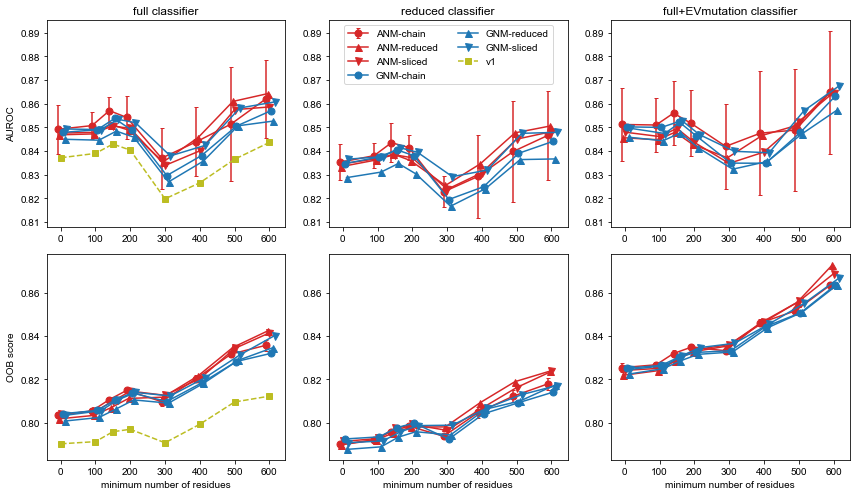

In [21]:
fig, ax = plt.subplots(2, 3, figsize=(12,7))
fig.subplots_adjust(wspace=0.2)

ax[0,0].set_title('full classifier')
ax[0,1].set_title('reduced classifier')
ax[0,2].set_title('full+EVmutation classifier')
ax[0,0].set_ylabel('AUROC')
ax[1,0].set_ylabel('OOB score')
   
x = [1, 100, 150, 200, 300, 400, 500, 600]
k = 0
for ENM in ['ANM', 'GNM']:
    col = 'C0' if ENM=='GNM' else 'C3'
    for model in ['chain', 'reduced', 'sliced']:
        k = k + 1
        if model == 'chain':
            mk = 'o'
        elif model == 'reduced':
            mk = '^'
        else:
            mk = 'v'
        for i, version in enumerate(['full', 'reduced', 'EVmut']):
            scheme = f'{ENM}-{model}-{version}'
            AUC = [CV_summaries_2[f'{n}-{scheme}']['mean AUROC'][0] for n in x]
            OOB = [CV_summaries_2[f'{n}-{scheme}']['mean OOB score'][0] for n in x]
            if scheme.startswith('ANM-chain'):
                AUC_e = [CV_summaries_2[f'{n}-{scheme}']['mean AUROC'][1] for n in x]
                OOB_e = [CV_summaries_2[f'{n}-{scheme}']['mean OOB score'][1] for n in x]
            else:
                AUC_e = None
                OOB_e = None
            xx = np.array(x) + 5*(k - 3)
            ax[0,i].errorbar(xx, AUC, yerr=AUC_e, capsize=2, c=col, marker=mk, ms=7,
                             label=f'{ENM}-{model}')
            ax[1,i].errorbar(xx, OOB, yerr=OOB_e, capsize=2, c=col, marker=mk, ms=7)

AUC = [CV_summaries_2[f'{n}-v1']['mean AUROC'][0] for n in x]
OOB = [CV_summaries_2[f'{n}-v1']['mean OOB score'][0] for n in x]
ax[0,0].errorbar(x, AUC, yerr=None, c='C8', ls='--', marker='s', label='v1')
ax[1,0].errorbar(x, OOB, yerr=None, c='C8', ls='--', marker='s')

ymin0 = min([a.get_ylim()[0] for a in ax[0,:]]) - .001
ymax0 = max([a.get_ylim()[1] for a in ax[0,:]]) + .001
ymin1 = min([a.get_ylim()[0] for a in ax[1,:]]) - .003
ymax1 = max([a.get_ylim()[1] for a in ax[1,:]]) + .003
for j in range(3):
    ax[0,j].set_ylim([ymin0, ymax0])
    ax[1,j].set_ylim([ymin1, ymax1])
    ax[1,j].set_xlabel('minimum number of residues')

handles, labels = ax[0,0].get_legend_handles_labels()
ax[0,1].legend(handles, labels, loc='upper center', ncol=2)

plt.tight_layout()
fig.savefig('local/figures/performances_comparison.png', dpi=300)

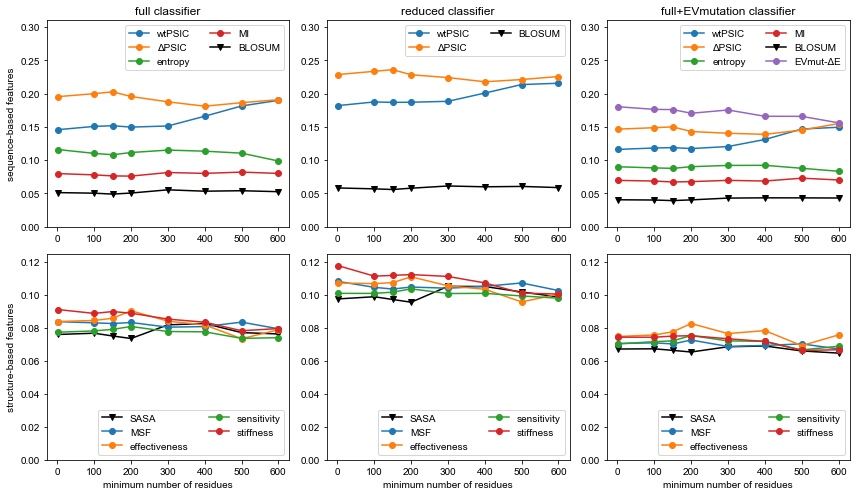

In [22]:
fig, ax = plt.subplots(2, 3, figsize=(12,7))
fig.subplots_adjust(wspace=0.2)

featsets = {}
featsets['full'] = [
    'wtPSIC', 'ΔPSIC', 'SASA', 'MSF', 
    'effectiveness', 'sensitivity', 'stiffness', 
    'entropy', 'MI', 'BLOSUM']
featsets['reduced'] = [
    'wtPSIC', 'ΔPSIC', 'SASA', 'MSF', 
    'effectiveness', 'sensitivity', 'stiffness', 'BLOSUM']
featsets['EVmut'] = featsets['full'] + ['EVmut-ΔE',]
SEQ_feats = ['wtPSIC', 'ΔPSIC', 'BLOSUM', 'entropy', 'MI', 'EVmut-ΔE']

ax[0,0].set_title('full classifier')
ax[0,1].set_title('reduced classifier')
ax[0,2].set_title('full+EVmutation classifier')
ax[0,0].set_ylabel('sequence-based features')
ax[1,0].set_ylabel('structure-based features')
for j in range(3):
    ax[0,j].set_ylim([0, .31])
    ax[1,j].set_ylim([0, .125])
    ax[1,j].set_xlabel('minimum number of residues')

x = [1, 100, 150, 200, 300, 400, 500, 600]

for i, (version, featset) in enumerate(featsets.items()):
    for j,f in enumerate(featset):
        ss = [CV_summaries_2[f'{n}-ANM-chain-{version}']['feat. importances'][0][j] for n in x]
        if f in ['BLOSUM', 'SASA']:
            m = 'kv-'
        elif f == 'EVmut-DeltaE':
            m = '^-'
        else:
            m = 'o-'
        if f in SEQ_feats:
            ax[0,i].plot(x, ss, m, label=f)
        else:
            ax[1,i].plot(x, ss, m, label=f)
            
for a in ax[0]:
    a.legend(loc='upper right', ncol=2)
for a in ax[1]:
    a.legend(loc='lower right', ncol=2)

plt.tight_layout()
fig.savefig('local/figures/feat_imp_comparison.png', dpi=300)

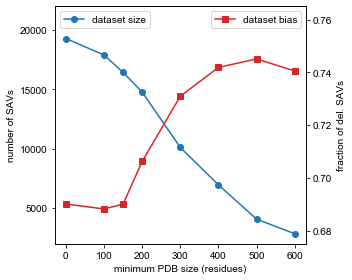

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))

x = [1, 100, 150, 200, 300, 400, 500, 600]

y = np.array([CV_summaries_2[f'{n}-ANM-chain-full']['dataset size'] for n in x])
h1 = ax.plot(x, y, '-o', label='dataset size')

ax2 = ax.twinx()
h2 = ax2.plot(x, [CV_summaries_2[f'{n}-ANM-chain-full']['dataset bias'] for n in x], 
              'C3-s', label='dataset bias')

ax.set_xlabel('minimum PDB size (residues)')
ax.set_ylabel('number of SAVs')
ax2.set_ylabel('fraction of del. SAVs')

ax.set_ylim((2000, 22000))
ax2.set_ylim((.675, .765))

ax.locator_params(nbins=5, axis='y')
ax2.locator_params(nbins=7, axis='y')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
fig.savefig('local/figures/dataset_size_vs_bias.png', dpi=300)

## 3. Hyperparameter optimization

The main hyperparameters of a Random Forest classifier are:

* the number of "trees" in the "forest"
* the maximum number of features used for training a single tree.

Based on the previous analysis, we will perform hyperparameter optimization only on the `'150-ANM-chain-v2'` classification scheme.

In [24]:
# this cell requires ~3 hours to complete

if os.path.isfile('local/results/CV_summaries_3.pkl'):
    CV_summaries_3 = pickle.load(open('local/results/CV_summaries_3.pkl', 'rb'))
    print('A pickle containing precomputed results has been found. \n'
          'Please delete it if you wish to run the analysis again. \n'
          'Log saved in local/results/RF_optimization_3.log \n')
    ! head -10 local/results/RF_optimization_3.log; echo '...'
else:   
    LOGGER.start('local/results/RF_optimization_3.log')
    CV_summaries_3 = {}
    
    ID_subset = ID[ ID['PDB_length'] >= 150 ]
    sel = ['SAV_coords', 'true_label'] + rd.DEFAULT_FEATSETS['full']
    ID_subset = ID_subset[sel]
    
    for n_trees in [100, 500, 1000, 1500, 2000]:
        for max_nfeats in range(2, len(featset)-1):

            scheme = f'{n_trees}-{max_nfeats}'

            LOGGER.info(f'PARAMETERS: {scheme}')

            # create folder
            folder = f'local/results/hyp_optimization-{scheme}'
            os.mkdir(folder)

            # run cross-validation
            CV_summaries_3[scheme] = rd.RandomForestCV(
                ID_subset, n_estimators=n_trees, max_features=max_nfeats)

            # move figures into folder
            for file in glob('*png'):
                os.rename(file, os.path.join(folder, file))

            LOGGER.info('')
                    
    # store all cross-validation results into a pickle
    pickle.dump(CV_summaries_3, open('local/results/CV_summaries_3.pkl', 'wb'))

    LOGGER.close('local/results/RF_optimization_3.log')

A pickle containing precomputed results has been found. 
Please delete it if you wish to run the analysis again. 
Log saved in local/results/RF_optimization_3.log 

Logging started at 2019-10-26 00:55:05.698326
PARAMETERS: 100-2
3918 out of 20361 cases ignored with missing features.
CV iteration # 1:   AUROC = 0.852   AUPRC = 0.913   OOB score = 0.808
CV iteration # 2:   AUROC = 0.860   AUPRC = 0.921   OOB score = 0.808
CV iteration # 3:   AUROC = 0.843   AUPRC = 0.908   OOB score = 0.808
CV iteration # 4:   AUROC = 0.857   AUPRC = 0.918   OOB score = 0.806
CV iteration # 5:   AUROC = 0.850   AUPRC = 0.918   OOB score = 0.808
CV iteration # 6:   AUROC = 0.852   AUPRC = 0.918   OOB score = 0.809
CV iteration # 7:   AUROC = 0.857   AUPRC = 0.919   OOB score = 0.807
...


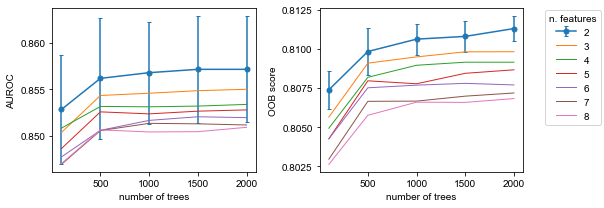

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5,3))
fig.subplots_adjust(wspace=0.2)

x = [100, 500, 1000, 1500, 2000]

for max_nfeats in range(2, len(rd.DEFAULT_FEATSETS['full'])-1):

    summ = {n: CV_summaries_3[f'{n}-{max_nfeats}'] for n in x}
    
    AUROC = np.array([summ[n]['mean AUROC'][0] for n in x])
    OOB = np.array([summ[n]['mean OOB score'][0] for n in x])
    if max_nfeats == 2:
        AUROC_e = np.array([summ[n]['mean AUROC'][1] for n in x])
        OOB_e = np.array([summ[n]['mean OOB score'][1] for n in x])
        kwargs = {'lw': 1.5, 'ls': '-', 'marker': 'o', 'markersize': 5}
    else:
        AUROC_e, OOB_e = None, None
        kwargs = {'lw': 1, 'ls': '-', 'marker': None}

    ax1.errorbar(x, AUROC, yerr=AUROC_e, **kwargs, capsize=2)
    ax2.errorbar(x, OOB, yerr=OOB_e, **kwargs, capsize=2, 
                 label=f'{max_nfeats}')

ax1.set_xlabel('number of trees')
ax1.set_ylabel('AUROC')
ax2.set_xlabel('number of trees')
ax2.set_ylabel('OOB score')

ax1.locator_params(nbins=5, axis='y')
ax2.locator_params(nbins=5, axis='y')

lgd = fig.legend(title='n. features', bbox_to_anchor=(1, 0.94), 
                 loc='upper left', ncol=1)
plt.tight_layout()
fig.savefig('local/figures/hyp_optimization.png', bbox_extra_artists=(lgd,), 
            bbox_inches='tight', dpi=300)

In [26]:
plt.rcParams.update(plt.rcParamsDefault)